(ch:annulus)=
# Annulus & Local Sky

An [annulus](https://en.wikipedia.org/wiki/Annulus_(mathematics)) (plural can be annuli or annuluses) basically a circular ring. In astronomy, it can also be a random shaped ring-like shape, e.g., the region between two rectangles.

In [12]:
# Ignore this cell if you encounter errors
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-04-20 22:10:32 (KST = GMT+0900) 
0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.12.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.24.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 photutils  1.6.0
8 version_information 1.0.4


In [13]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.modeling.functional_models import Moffat2D

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

In [14]:
# 1. Load data
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])
ccd.data[310:320, 299] += np.arange(10)**2
ccd.data[295:305, 250] += 30*np.arange(10)**2
another_star = Moffat2D(amplitude=500, x_0=290, y_0=300, gamma=7, alpha=2.5)
yy, xx = np.mgrid[:ccd.shape[0], :ccd.shape[1]]
ccd.data = ccd.data + another_star(yy, xx)

cut = Cutout2D(ccd, position=(273, 314), size=(100,100))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## Review of ``Aperture``
In previous notes, you have learned how to detect objects in the image, and then how to set up apertures. Then you learned how to do photometry. The example I showed in the note, i.e., measuring the star's flux using the fluxes of two different apertures, are reasonable when a 2-D measurement is impossible. If we know the pixel values around the star (the 2-D information)

In this note, I will show you the power of 2-D analyses for obtaining better photometry.

First, result from the previous note as a reference:

Inner aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 12.0

Outer aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 24.0
flux at aperture 1 and 2 are 94709.65 and 208071.27
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 83.53
∴ flux0 = 56922.44


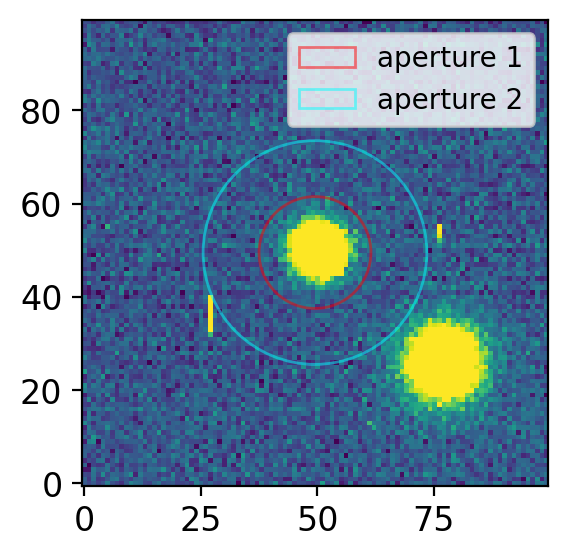

In [15]:
# 2. Set the two "apertures"
ap1 = CircularAperture(positions=cut.center_cutout, r=12)
ap2 = CircularAperture(positions=cut.center_cutout, r=24)
# I used radius 12 and 24 because I know the star is <20 pixels in diameter.
print("Inner aperture:\n", ap1)
print()
print("Outer aperture:\n", ap2)

# 3. Perform photometry
phot = aperture_photometry(cut.data, [ap1, ap2])
flux1 = phot['aperture_sum_0'][0]
flux2 = phot['aperture_sum_1'][0]

# 4. Calculate the sky flux and the total flux
flux_s = (flux2 - flux1) / (ap2.area - ap1.area)
flux0 = flux1 - flux_s * np.pi * 12**2

# 5. Print out the results
print(f"flux at aperture 1 and 2 are {flux1:.2f} and {flux2:.2f}")
print(f"sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = {flux_s:.2f}")
print(f"∴ flux0 = {flux0:.2f}")


# Let me visualize for you
fig, axs = plt.subplots(1, 1, figsize=(3, 4), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs, cut.data, zscale=True)
ap1.plot(color='r', lw=1, alpha=0.5, label="aperture 1")
ap2.plot(color='cyan', lw=1, alpha=0.5, label="aperture 2")
axs.legend(fontsize=10,)
plt.tight_layout()

```{note} 
Take a note of the sky value 83.53 ADU/pix & flux 56922.44 ADU.
```

```{important} 
Before proceed, please read the **aperture mask part** of [photutils/Aperture](https://photutils.readthedocs.io/en/stable/aperture.html).
```

## ``Annulus`` Object
Now you have learned how to initialize an annulus (basically it is similar to `Aperture` object) and make a "mask" to extract the pixels in it. I will extract only the pixels with center is inside an annulus of inner/outer radii of 20 and 28:

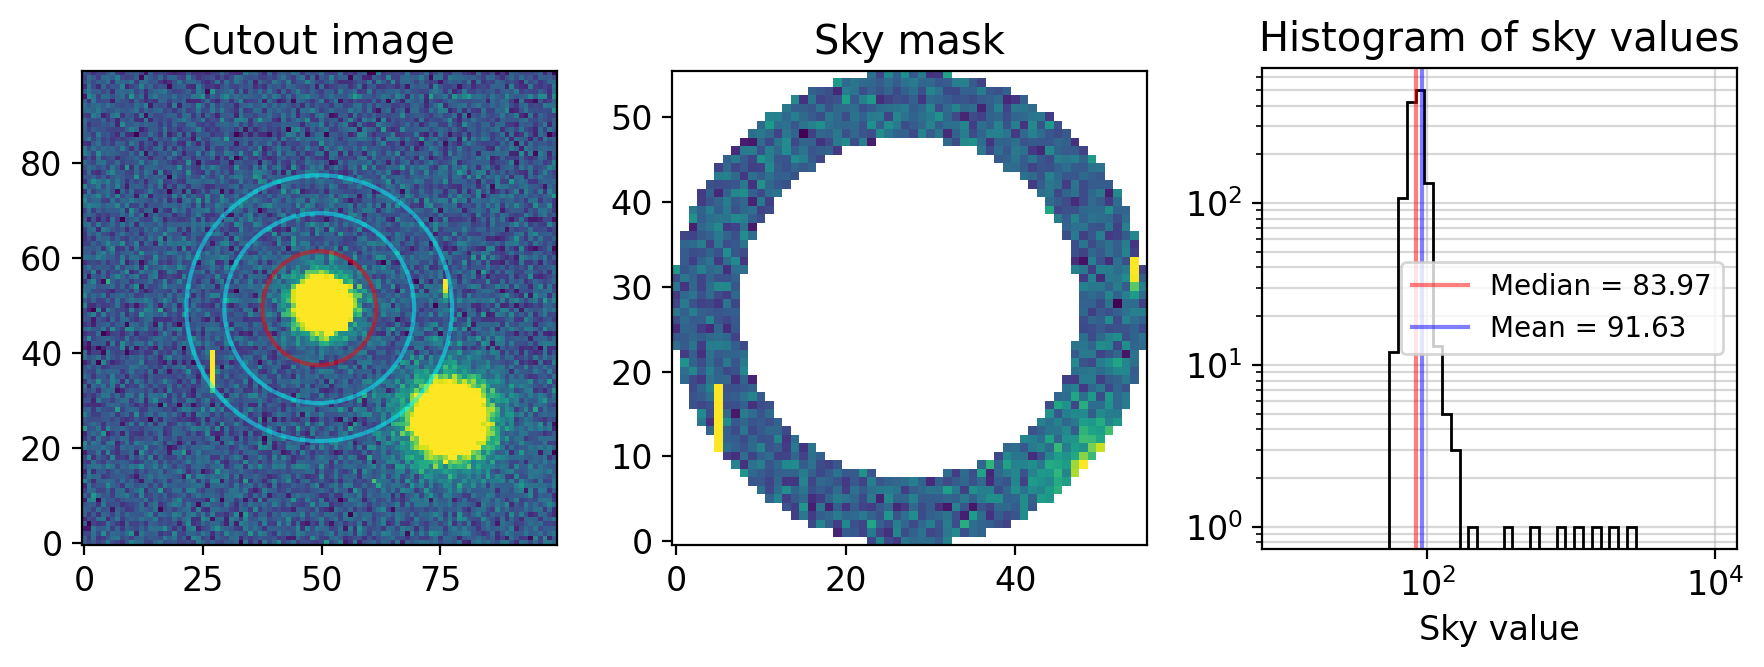

In [16]:
an1 = CircularAnnulus(positions=cut.center_cutout, r_in=20, r_out=28)
skymask = an1.to_mask(method='center')
skymap = skymask.multiply(cut.data, fill_value=np.nan)
skymap.mask = skymask.data == 0
skyvals = skymap.flatten()
med = np.nanmedian(skyvals.compressed())
avg = np.nanmean(skyvals.compressed())

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs[0], cut.data, zscale=True)
ap1.plot(axs[0], color='r', lw=1.5, alpha=0.5)
an1.plot(axs[0], color='cyan', lw=1.5, alpha=0.5)

vis.norm_imshow(axs[1], skymap, zscale=True)
axs[2].hist(skyvals.flatten(), bins=np.logspace(1, 4, 50), histtype='step', color='k')
axs[2].grid(which='both', alpha=0.5)
axs[2].axvline(med, color='r', lw=1.5, alpha=0.5, label=f'Median = {med:.2f}')
axs[2].axvline(avg, color='b', lw=1.5, alpha=0.5, label=f'Mean = {avg:.2f}')

axs[0].set_title("Cutout image")
axs[1].set_title("Sky mask")
axs[2].set(title="Histogram of sky values", xscale='log', yscale="log", xlabel='Sky value')
axs[2].legend(loc=5, fontsize=10)
plt.tight_layout()
plt.show();


```{admonition} Practice
:class: tip
1. What does ``skymask.data`` mean? 
2. Why did I use ``skyvals[skymask.data==0] = np.nan``? (What will happen without this line?)
```

## Robust Sky
Now let me ask you. The flux within the red aperture will contain both the star's flux and the sky flux. And although I didn't mention explicitly, you can easily understand the sky annulus (cyan) is set to estimate this sky value. From the right panel, how would you calculate the sky value?

The histogram includes the distribution of the sky values. However, you can see some bright cosmic-ray spots at the left and right and a nearby star at the bottom-right part in the annulus (that I artifically added when I loaded it for visualization purpose). Because of this, the histogram is skewed to the right. Therefore, average and median are quite diffent, and you can see simple average value of the pixels is not a good option. Even median might have been affected.

### Sigma-Clipping
One suggestion: How about use sigma-clipping?

Number of rejected sky values: 27


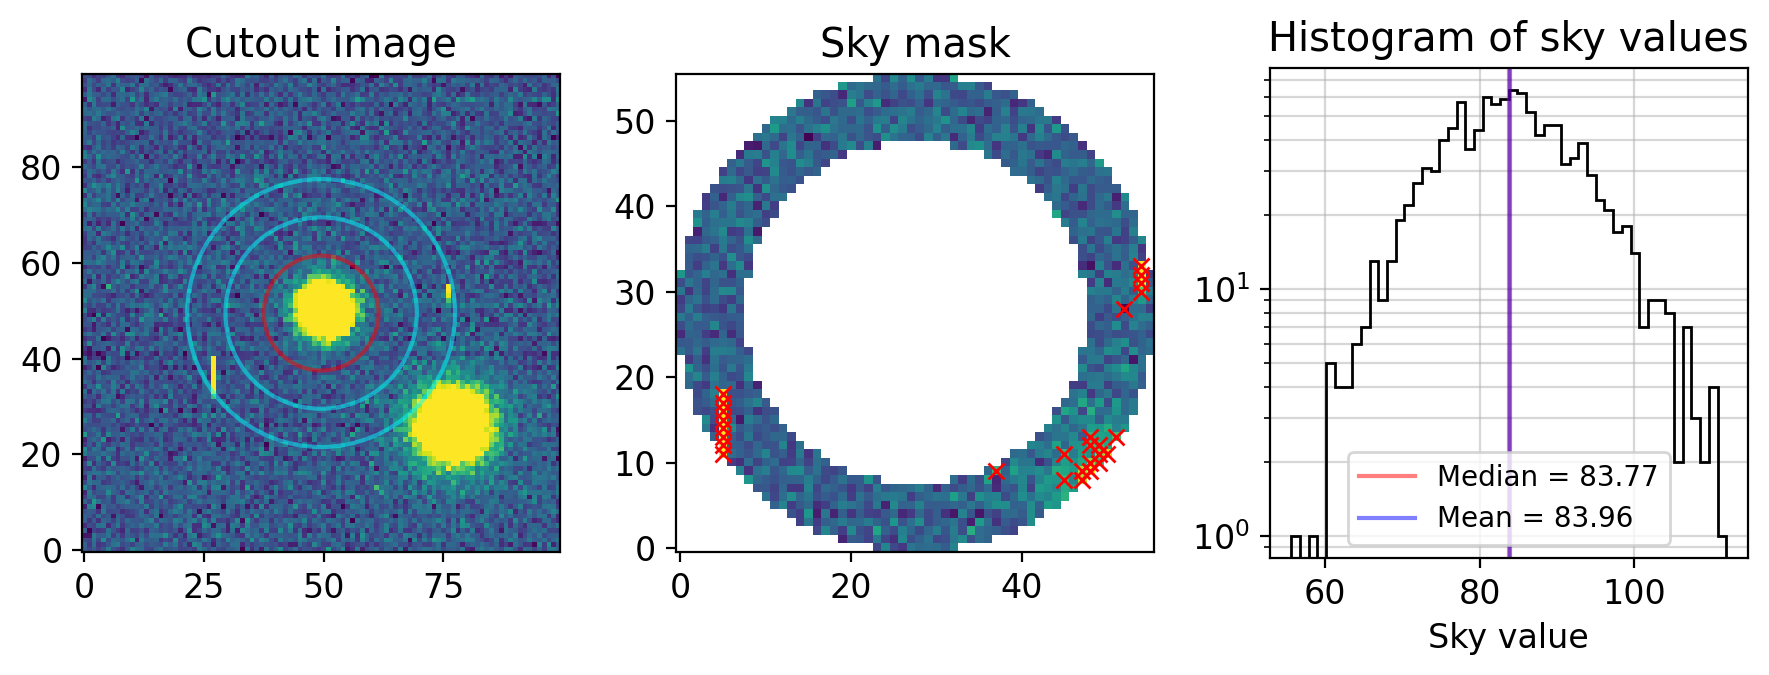

In [17]:
from astropy.stats import sigma_clip

sigc = sigma_clip(skymap)  # default 3-sigma 5-iteration clipping
med = np.nanmedian(sigc.compressed())
avg = np.nanmean(sigc.compressed())
std = np.nanstd(sigc.compressed(), ddof=1)
sigc_masked = (skymap.mask ^ sigc.mask)
# What is ^? --> Search for the "bitwise XOR operator in Python"
print("Number of rejected sky values:", np.sum(sigc_masked))

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs[0], cut.data, zscale=True)
ap1.plot(axs[0], color='r', lw=1.5, alpha=0.5)
an1.plot(axs[0], color='cyan', lw=1.5, alpha=0.5)

vis.norm_imshow(axs[1], skymap, zscale=True)
axs[1].plot(*np.argwhere(sigc_masked).T[::-1], "rx")

axs[2].hist(sigc.compressed(), bins=50, histtype='step', color='k')
axs[2].grid(which='both', alpha=0.5)
axs[2].axvline(med, color='r', lw=1.5, alpha=0.5, label=f'Median = {med:.2f}')
axs[2].axvline(avg, color='b', lw=1.5, alpha=0.5, label=f'Mean = {avg:.2f}')

axs[0].set_title("Cutout image")
axs[1].set_title("Sky mask")
axs[2].set(title="Histogram of sky values", yscale="log", xlabel='Sky value')
axs[2].legend(fontsize=10)
plt.tight_layout()
plt.show();

Note that the 27 pixels masked in sigma-clipping are marked by red crosses and masked in this version of plot.

Also, the median and mean are now slightly lowered (because most rejections were for high pixel values) and they match quite well with each other.

For elementary photometry, this is ehough. Even for publication level, if we are sure there are no nearby objects, this is a reasonable guess. 

### Mode Estimation
However, you may still feel uncomfortable because some pixels that could have been affected by the nearby star (lower right corner) are remaining. Long story short, the mode or the modeal value (the most frequent value of sky) is a more robust statistic than median. However, it is difficult to find the mode, because if you set the histogram bin to, e.g., 0.0000001 ADU, any bin will have height 1. Thus, it is bin-size dependent. [Doodon A. T. 1917](https://academic.oup.com/biomet/article/11/4/425/192665) first proved that the mode of a unimodal distribution should be approximately related to mean and median by

$$
\mathrm{mode} = 3\times\mathrm{median} - 2\times \mathrm{mean} ~.
$$

In practical observational astronomy, [Bertin & Arnouts (1996)](https://ui.adsabs.harvard.edu/abs/1996A%26AS..117..393B/abstract) argued that 

$$
\mathrm{mode} = 2.5\times\mathrm{median} - 1.5\times \mathrm{mean} ~
$$

is more robust. In their software (Source Extractor, or SExtractor, SEx, SE), when ``(mean - median) / std > 0.3``, median is used instead (``std``=sky standard deviation).

(avg - med) / std =  0.019761071062240367


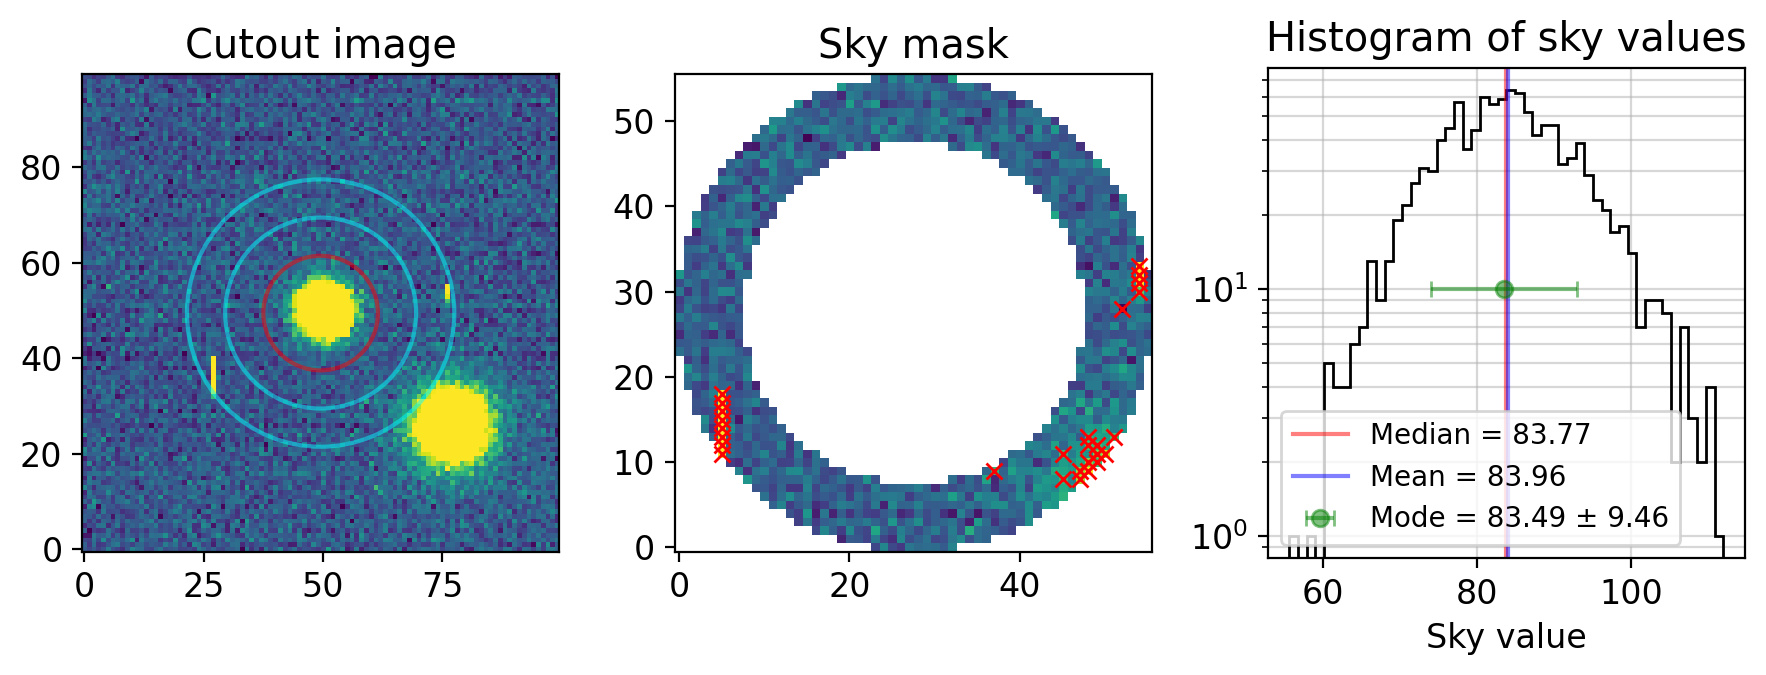

∴ star flux = 56939.21


In [18]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=False, gridspec_kw=None)

# === >>> Updated part
ams = (avg - med) / std
print("(avg - med) / std = ", ams)
mode = med if ams > 0.3 else 2.5*med - 1.5*avg
# === <<< Updated part

vis.norm_imshow(axs[0], cut.data, zscale=True)
ap1.plot(axs[0], color='r', lw=1.5, alpha=0.5)
an1.plot(axs[0], color='cyan', lw=1.5, alpha=0.5)

vis.norm_imshow(axs[1], skymap, zscale=True)
axs[1].plot(*np.argwhere(sigc_masked).T[::-1], "rx")

axs[2].hist(sigc.compressed(), bins=50, histtype='step', color='k')
axs[2].grid(which='both', alpha=0.5)
axs[2].axvline(med, color='r', lw=1.5, alpha=0.5, label=f'Median = {med:.2f}')
axs[2].axvline(avg, color='b', lw=1.5, alpha=0.5, label=f'Mean = {avg:.2f}')

# === >>> Updated part
axs[2].errorbar(mode, 10 , xerr=std, color='g', lw=1.5, alpha=0.5, capsize=3, marker="o",
                ls="", label=f'Mode = {mode:.2f} ± {std:.2f}')
# === <<< Updated part

axs[0].set_title("Cutout image")
axs[1].set_title("Sky mask")
axs[2].set(title="Histogram of sky values", yscale="log", xlabel='Sky value')
axs[2].legend(fontsize=10)
plt.tight_layout()
plt.show();
print(f"∴ star flux = {flux1 - mode*ap1.area:.2f}")

```{admonition} Example
:class: tip
In the previous primitive calculation, sky = 83.53 ADU/pix & flux = 56922 ADU.

Now it is 83.49 ADU/pix & 56939 ADU. Therefore, the primitive calculation underestimated the flux by only 14.
```

```{admonition} Practice
:class: tip
Run the primitive calculation up in this lecture note with the outer aperture radius 28. You will obtain a vastly different value of sky = 88.25 & flux0 = 54786. This underestimates the flux by 2150 ADU, or 4% of the flux!

The main reason is because the sky value is over-estimated by ~5 ADU/pix.
```

```{admonition} Practice
:class: tip
If the sky value per pixel ($m_s$) is miscalculated by a small amount $\Delta m_s$, the sky subtraction will result in $\pi r_\mathrm{ap}^2 \times \Delta m_s$. In case where the observation is oversampled (i.e., seeing FWHM ~ 10 pixels), $\Delta m $ of only 1 will result in 300 ADU offset. This is critical problem for accurate photometry of faint objects. That's why accurate sky estimation is important. 
```
The above processes are simply calculated in one-line code from `ysphotutilpy`:

In [19]:
import ysfitsutilpy as yfu
import ysphotutilpy as ypu

ap = CircularAperture(cut.center_original, r=12)
an = CircularAnnulus(cut.center_original, r_in=20, r_out=28)
ypu.apphot_annulus(ccd, ap, an)

,id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,ssky,nsky,nrej,aparea,source_sum,source_sum_err,mag,merr,snr,bad,nbadpix
0,1,272.5,313.5,94709.650653,0.0,83.491008,9.459667,1181,27,452.389342,56939.208432,201.201874,-7.44315,0.003837,282.995419,0,0


* ``nsky``: The number of sky pixels used for this calculation (after rejecting outliers)
* ``nrej``: The number of rejected pixels in sky
* ``msky``: The estimated sky value
* ``ssky``: The standard deviation of the remaining sky pixels 
* ``aperture_sum``: pixel value sum within the aperture
* ``source_sum``: ``aperture_sum - aparea*msky``
* ``mag``: The instrumental magnitude $m = -2.5 \lg (\texttt{source sum})$

To properly calculate error, you need to know the gain and readout noise. By default, gain=1 and rdnoise=0 are used.

